# Boxplot of DE junctions

In [1]:
library(ggpubr)
library(ggplot2)
library(tidyverse)
suppressMessages(library(data.table))

Loading required package: ggplot2

-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
ggplot_save <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


subset_deg <- function(fn, thres){
    jt = fread(fn) %>% 
        rename(Feature='gene_id', 
               ensemblID=ensembl_gene_id, Symbol=hgnc_symbol) %>% 
        filter(adj.P.Val < thres) %>% 
        select(Feature, ensemblID, Symbol, logFC, adj.P.Val)
    return(jt)
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Load DEG annotation

In [3]:
fn1 = '../../_m/genes/diffExpr_interaction_full.txt'
fn2 = '../../_m/genes/diffExpr_maleVfemale_full.txt'
fn3 = '../../_m/genes/diffExpr_szVctl_full.txt'
genes = subset_deg(fn1, 0.05)
sex = subset_deg(fn2, 1)
sz = subset_deg(fn3, 1)

In [4]:
df = genes %>% 
        inner_join(sex, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Sex")) %>%
        inner_join(sz, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Diagnosis"))
df = add_symnum(df)
df

Feature,ensemblID,Symbol,logFC,adj.P.Val,logFC_Sex,adj.P.Val_Sex,logFC_Diagnosis,adj.P.Val_Diagnosis,FDR,p.signif
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>


## Load phenotypes

In [5]:
pheno_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/phenotypes/combine_files/_m/CMC_phenotypes_all.csv'
pheno = fread(pheno_file) %>%
    mutate_if(is.character, as.factor) %>% 
    select("RNAseq:Sample_RNA_ID", Dx, "Reported Gender", 'Ethnicity', "Age of Death") %>%
    rename(Sex="Reported Gender", Age="Age of Death", SampleID="RNAseq:Sample_RNA_ID")
levels(pheno$Dx) <- c("AFF", "BP", "CTL", "SZ", "Unknown")
pheno %>% head(2)

SampleID,Dx,Sex,Ethnicity,Age
<fct>,<fct>,<fct>,<fct>,<fct>
CMC_HBCC_RNA_PFC_3158,CTL,Male,Caucasian,26
CMC_HBCC_RNA_PFC_3152,CTL,Male,African-American,0


## Load residualized expression

In [18]:
res_file = '../../_m/genes/residualized_expression.tsv'
resdf = fread(res_file) %>%
    column_to_rownames(var="V1") %>% t
resdf = as.data.frame(resdf) %>% 
    rownames_to_column() %>% 
    rename(SampleID=rowname) %>% 
    select(SampleID, df$Feature)
resdf %>% head(2)

Warning message in fread(res_file):
"Detected 858 column names but the data has 859 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,SampleID,ENSG00000067048.16
,<chr>,<dbl>
1,MSSM_RNA_PFC_1,0.7447437
2,MSSM_RNA_PFC_2,0.7964711


## Merge data

In [21]:
gg = pheno %>% inner_join(resdf, by='SampleID')
gg$Dx = fct_drop(gg$Dx)
gg %>% dim
gg %>% head(2)

Warning message:
"Column `SampleID` joining factor and character vector, coercing into character vector"


[1] 858   6

,SampleID,Dx,Sex,Ethnicity,Age,ENSG00000067048.16
,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,CMC_HBCC_RNA_PFC_3158,CTL,Male,Caucasian,26,0.6798623
2,CMC_HBCC_RNA_PFC_3152,CTL,Male,African-American,0,0.5871001


In [23]:
dft = gg %>% pivot_longer(-c(SampleID, Age, Sex, Ethnicity, Dx), 
                          names_to="Feature", values_to="Res") %>% 
    inner_join(df, by="Feature") %>% mutate_at("Feature", as.factor)
dft[1:2, 1:10]

SampleID,Dx,Sex,Ethnicity,Age,Feature,Res,ensemblID,Symbol,logFC
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
CMC_HBCC_RNA_PFC_3158,CTL,Male,Caucasian,26,ENSG00000067048.16,0.6798623,ENSG00000067048,DDX3Y,-1.033426
CMC_HBCC_RNA_PFC_3152,CTL,Male,African-American,0,ENSG00000067048.16,0.5871001,ENSG00000067048,DDX3Y,-1.033426


Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


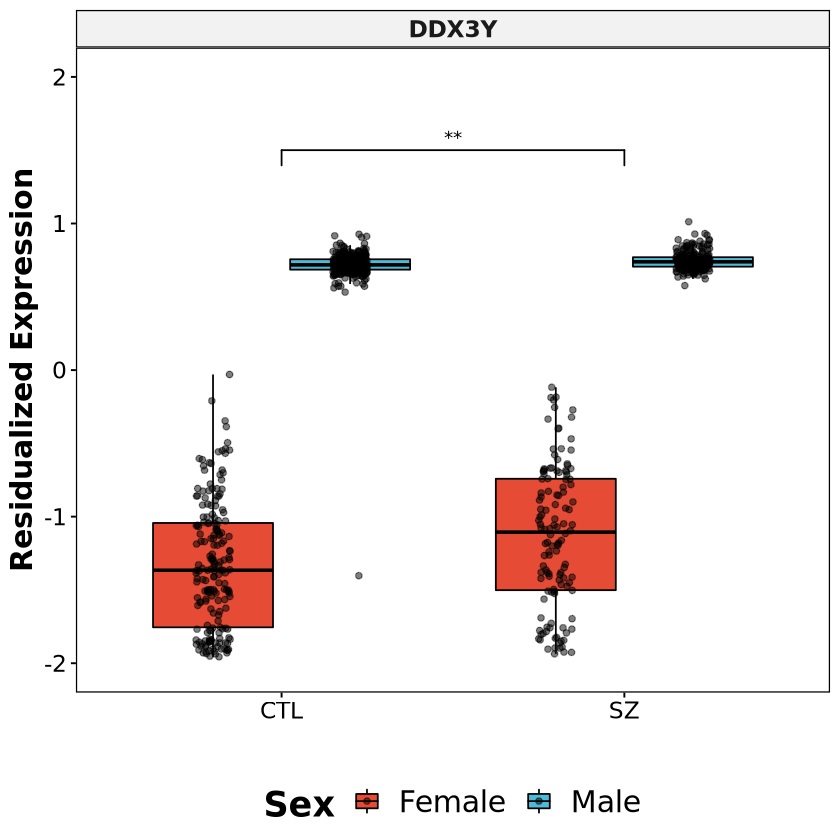

In [36]:
tmp = df %>% mutate(group1='CTL', group2='SZ', y_pos=1.5)

bxp <- ggboxplot(dft, x="Dx", y="Res", fill="Sex", add='jitter',
                 panel.labs.font=list(face='bold', size = 14),
                 facet.by=c("Symbol"), palette="npg", xlab='', 
                 ylim=c(-2, 2), ylab='Residualized Expression', 
                 add.params=list(alpha=0.5), legend="bottom", 
                 outlier.shape=NA) +
        geom_signif(data=tmp, 
                    aes(xmin=group1, xmax=group2, 
                        annotations=p.signif, y_position=y_pos), 
                    manual=TRUE) + 
        font("xy.title", size=18, face="bold") + font("xy.text", size=14) + 
        font("legend.title", size=21, face="bold") + font("legend.text", size=18)
         
bxp

In [10]:
ggplot_save(bxp, 'cmc_gene_interaction', 4, 4)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()